In [1]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.2/631.2 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 31.5 MB/s eta 0:00:00
2.19.0-dev20241121


In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2024-11-24 14:27:05--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.03s   

2024-11-24 14:27:06 (10.0 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2024-11-24 14:27:06--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

In [3]:
df = pd.read_csv("train-data.tsv",sep='\t', header= None)
df.columns =['label', 'message']
df.tail()

,label,message
4174,ham,just woke up. yeesh its late. but i didn't fal...
4175,ham,what do u reckon as need 2 arrange transport i...
4176,spam,free entry into our £250 weekly competition ju...
4177,spam,-pls stop bootydelious (32/f) is inviting you ...
4178,ham,tell my bad character which u dnt lik in me. ...


In [4]:
df.describe()

,label,message
count,4179,4179
unique,2,3935
top,ham,"sorry, i'll call later"
freq,3619,22


In [5]:
df.groupby('label').describe().T

label                              ham  \
message count                     3619   
        unique                    3430   
        top     sorry, i'll call later   
        freq                        22   

label                                                        spam  
message count                                                 560  
        unique                                                505  
        top     hmv bonus special 500 pounds of genuine hmv vo...  
        freq                                                    3

In [6]:
# Get all the ham and spam emails
ham_msg = df[df.label =='ham']
spam_msg = df[df.label=='spam']# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

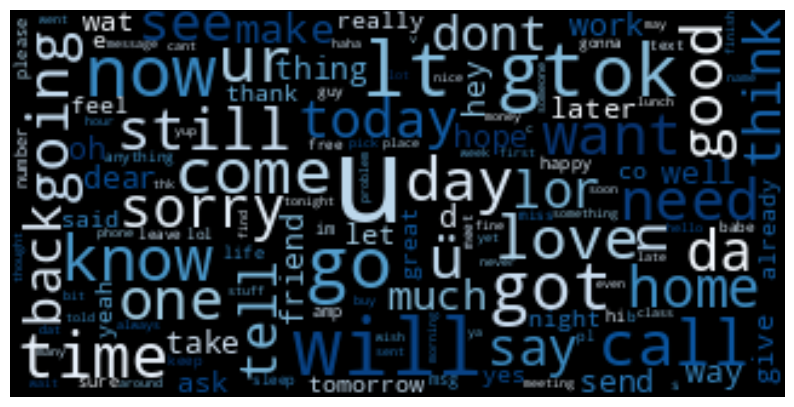

In [7]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
ham_msg_cloud = WordCloud(width =320, height =160, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(10,8))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

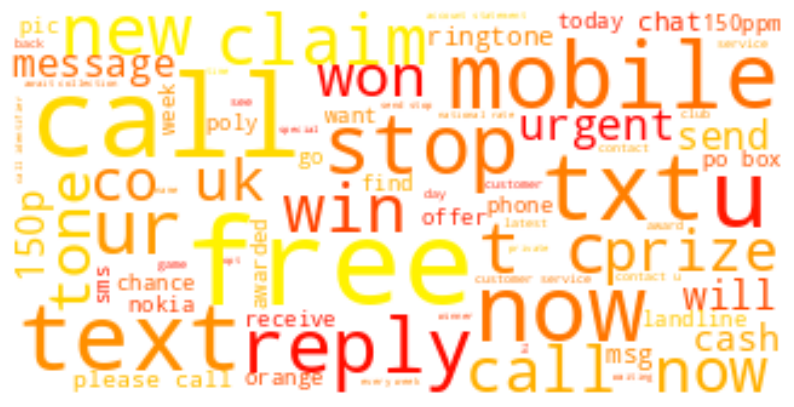

In [8]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
ham_msg_cloud = WordCloud(width =320, height =160, stopwords=STOPWORDS,max_font_size=50, background_color ="white", colormap='autumn').generate(spam_msg_text)
plt.figure(figsize=(10,8))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

15.473887814313347

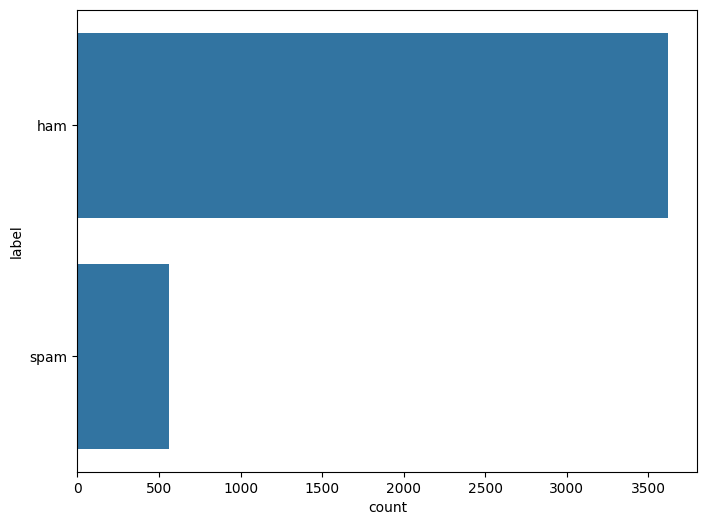

In [9]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.countplot(df.label)
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100 # 15.48%


In [10]:
# one way to fix it is to downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 0)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)#(747, 2) (747, 2)

(560, 2) (560, 2)


Text(0.5, 1.0, 'Distribution of ham and spam email messages (after downsampling)')

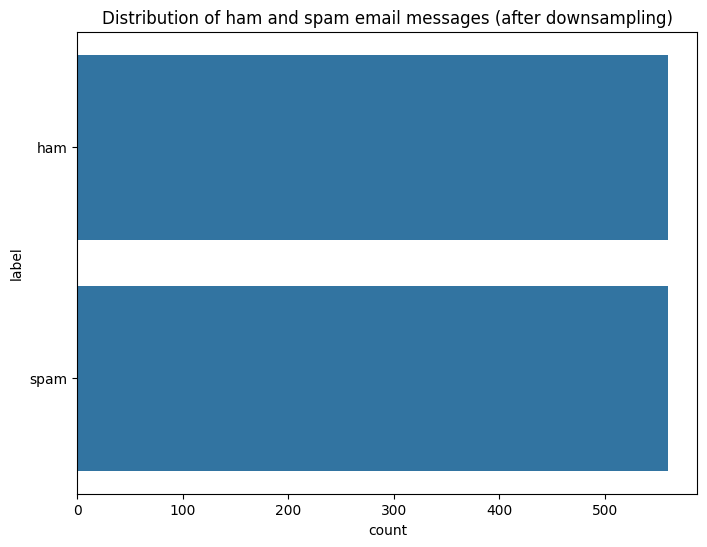

In [14]:
#msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
msg_df = pd.concat([ham_msg_df, spam_msg_df]).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(msg_df.label)
plt.title('Distribution of ham and spam email messages (after downsampling)')

In [17]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len) #Calculate average length by label types
labels = msg_df.groupby('label')['text_length'].mean()
labels

,text_length
label,
ham,72.403571
spam,138.750000


Preprocessing:

In [18]:
df_test = pd.read_csv("valid-data.tsv",sep='\t', header= None)
df_test.columns =['label', 'message']
df_test.tail()

,label,message
1387,ham,true dear..i sat to pray evening and felt so.s...
1388,ham,"what will we do in the shower, baby?"
1389,ham,where are you ? what are you doing ? are yuou ...
1390,spam,ur cash-balance is currently 500 pounds - to m...
1391,spam,not heard from u4 a while. call 4 rude chat pr...


In [19]:
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
df_test['msg_type']= df_test['label'].map({'ham': 0, 'spam': 1})
print(msg_df.tail())
print(df_test.tail())

     label                                            message  text_length  \
1115  spam  free msg: single? find a partner in your area!...          151   
1116  spam  free2day sexy st george's day pic of jordan!tx...          154   
1117  spam  you are a winner you have been specially selec...          157   
1118  spam  free entry into our £250 weekly competition ju...          106   
1119  spam  -pls stop bootydelious (32/f) is inviting you ...          152   

      msg_type  
1115         1  
1116         1  
1117         1  
1118         1  
1119         1  
     label                                            message  msg_type
1387   ham  true dear..i sat to pray evening and felt so.s...         0
1388   ham               what will we do in the shower, baby?         0
1389   ham  where are you ? what are you doing ? are yuou ...         0
1390  spam  ur cash-balance is currently 500 pounds - to m...         1
1391  spam  not heard from u4 a while. call 4 rude chat pr...        

In [20]:
train_label = msg_df['msg_type']
train_msg = msg_df['message']
test_msg = df_test['message']
test_label = df_test['msg_type']
print(test_msg)
print(train_msg)

0       i am in hospital da. . i will return home in e...
1              not much, just some textin'. how bout you?
2       i probably won't eat at all today. i think i'm...
3       don‘t give a flying monkeys wot they think and...
4                                     who are you seeing?
                              ...                        
1387    true dear..i sat to pray evening and felt so.s...
1388                 what will we do in the shower, baby?
1389    where are you ? what are you doing ? are yuou ...
1390    ur cash-balance is currently 500 pounds - to m...
1391    not heard from u4 a while. call 4 rude chat pr...
Name: message, Length: 1392, dtype: object
0       they just talking thats it de. they wont any o...
1       the 2 oz guy is being kinda flaky but one frie...
2                          at 4. let's go to bill millers
3         hiya, probably coming home * weekend after next
4                       just finished. missing you plenty
                             

In [21]:
# Defining pre-processing hyperparameters
max_len = 50
trunc_type = "post"
padding_type = "post"
oov_tok = ""
vocab_size = 500

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [23]:
word_index = tokenizer.word_index
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 4051 unique tokens in training data. 


In [24]:
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,padding = padding_type, truncating = trunc_type)

In [25]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1120, 50)
Shape of testing tensor:  (1392, 50)


In [26]:
print(training_padded[0])

[114  32   1   1  36   1 114   1 100 483   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


Dense Spam Detection Model

In [27]:
vocab_size = 500 # As defined earlier
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [34]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_label, epochs=num_epochs, validation_data=(testing_padded, test_label),callbacks =[early_stop], verbose=2)

Epoch 1/30
35/35 - 0s - 9ms/step - accuracy: 0.9795 - loss: 0.0642 - val_accuracy: 0.9612 - val_loss: 0.1128
Epoch 2/30
35/35 - 1s - 16ms/step - accuracy: 0.9786 - loss: 0.0626 - val_accuracy: 0.9741 - val_loss: 0.0771
Epoch 3/30
35/35 - 0s - 8ms/step - accuracy: 0.9812 - loss: 0.0617 - val_accuracy: 0.9698 - val_loss: 0.0866
Epoch 4/30
35/35 - 0s - 6ms/step - accuracy: 0.9804 - loss: 0.0608 - val_accuracy: 0.9591 - val_loss: 0.1193
Epoch 5/30
35/35 - 0s - 10ms/step - accuracy: 0.9848 - loss: 0.0585 - val_accuracy: 0.9677 - val_loss: 0.0890


In [35]:
model.evaluate(testing_padded, test_label)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9653 - loss: 0.0990


[0.08901987969875336, 0.9676724076271057]

In [36]:
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

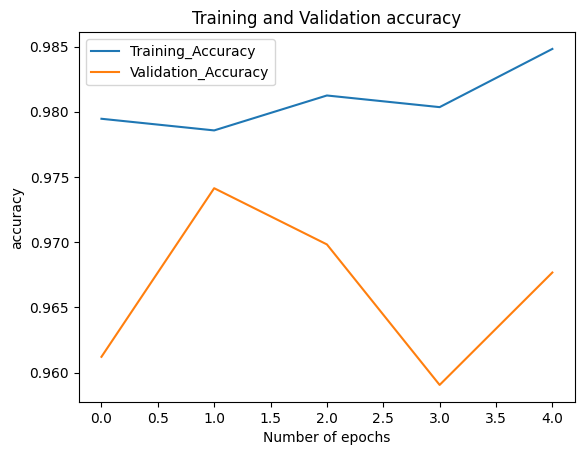

In [37]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

We select Dense architecture as a model for classifying the text messages for spam or ham. The dense classifier has simple structure and the loss and accuracy over epochs are more stable.

In [38]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text1):
  pred_text = []
  pred_text.append(pred_text1)
  new_seq = tokenizer.texts_to_sequences(pred_text)
  padded = pad_sequences(new_seq, maxlen =max_len,padding = padding_type,truncating=trunc_type)
  prediction = model.predict(padded)
  for i in prediction:
    if i > 0.5:
      return((float(i),"spam"))
    else:
      return((float(i),"ham"))

pred_text = " you have won £1000 cash! call to claim"

prediction = predict_message(pred_text)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
(0.9884061813354492, 'spam')


<ipython-input-38-46011090d027>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return((float(i),"spam"))


In [39]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


<ipython-input-38-46011090d027>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return((float(i),"ham"))
<ipython-input-38-46011090d027>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return((float(i),"spam"))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
You passed the challenge. Great job!
